# Analysis of XCO2 and SIF

Resolution: global, daily

Findings: In terms of maximizing the correlation coefficient between detrended SIF and XCO2, the optimal time lag is 116 days (about 4 months)

---

In [1]:
import numpy as np
import pandas as pd
import xarray

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [3]:
# Compute daily climatologies
df_sif_daily = DS_sif.sif.resample(time="1D").mean(dim="time").to_dataframe()
df_xco2_daily = DS_xco2.xco2.resample(time="1D").mean(dim="time").to_dataframe()
df_daily = pd.merge(df_sif_daily, df_xco2_daily, how="outer", on=["time"]).reset_index()

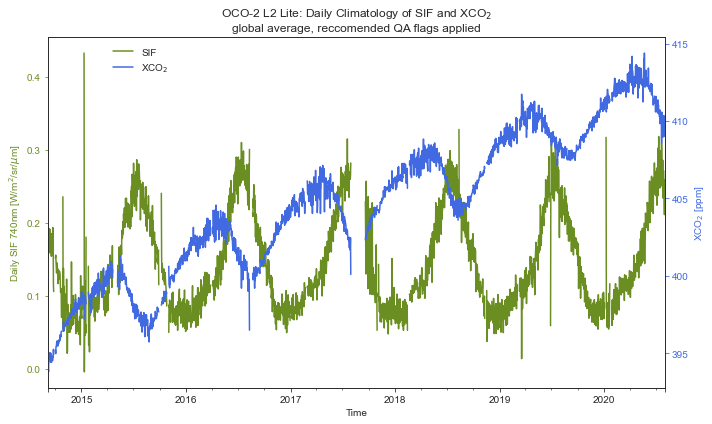

In [7]:
# Plot global daily climatology
sns.set_style("ticks")
fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

# Set variable colors
sif_color = "olivedrab"
xco2_color = "royalblue"

# Line plots
df_daily.plot(x="time", y="sif", color=sif_color, ax=ax1, legend=False, label="SIF")
df_daily.plot(x="time", y="xco2", color=xco2_color, ax=ax2, legend=False, label="XCO$_2$")

# Customize axes
# plt.locator_params(axis="x", nbins=8)
ax1.tick_params(axis="y", colors=sif_color)
ax2.tick_params(axis="y", colors=xco2_color)
ax1.yaxis.label.set_color(sif_color)
ax2.yaxis.label.set_color(xco2_color)
ax1.figure.legend(loc="upper left", bbox_to_anchor=(0.15, 0.9), frameon=False)

# Add titles
ax1.set_xlabel("Time")
ax1.set_ylabel("Daily SIF 740nm [W/m$^2$/sr/$\mu$m]")
ax2.set_ylabel("XCO$_2$ [ppm]")
ax1.set_title("OCO-2 L2 Lite: Daily Climatology of SIF and XCO$_2$\n"
              "global average, reccomended QA flags applied")

plt.tight_layout()
plt.savefig("../plots/daily_climatology_comparison.png")

In [4]:
# Interpolate missing values
df_daily_interp = df_daily.interpolate().set_index("time")

# Fit trends by least squares
X = (df_daily_interp.index - df_daily_interp.index[0]).days.values.reshape(-1, 1)
trend_sif = LinearRegression().fit(X, df_daily_interp.sif).predict(X)
trend_xco2 = LinearRegression().fit(X, df_daily_interp.xco2).predict(X)

# Remove trends
df_daily_interp["sif_anom"] = df_daily_interp.sif - trend_sif
df_daily_interp["xco2_anom"] = df_daily_interp.xco2 - trend_xco2

In [5]:
# Objective function
def objective_corr(lag):
    """
    Wrapper to compute Pearson's correlation coeffient between two pandas series
    with a lag applied to the second series. Returns the negative of the magnitude
    of the correlation coef. for minimization purposes.
    """
    lag = np.int(np.rint(lag))
#     return -np.abs(df_daily_interp.sif_anom.corr(df_daily_interp.xco2_anom.shift(lag)))
    return -np.abs(df_daily_interp.xco2_anom.corr(df_daily_interp.sif_anom.shift(lag)))

In [6]:
# Find the lag in days which maximizes the magnitude of the correlation coef. between global average residuals of SIF and XCO2
lag = minimize_scalar(objective_corr, bounds=[0, 360], method="Bounded")

# NOTE: does the integer rounding make this messy?
print(f"Optimal lag in days: {np.rint(lag.x)}")
lag

Optimal lag in days: 250.0


     fun: -0.7820210606441818
 message: 'Solution found.'
    nfev: 26
  status: 0
 success: True
       x: 250.16790086111143

In [7]:
lags = np.arange(0, 300)
lag_m = lags[np.argmin([objective_corr(t) for t in lags])]
print(f"Optimal lag in days: {lag_m}")

Optimal lag in days: 46


In [8]:
[print(t, objective_corr(t)) for t in lags];

0 -0.5022101670866399
1 -0.5084761044390556
2 -0.5245756590799728
3 -0.5340929175669378
4 -0.545453845619133
5 -0.5559996565883564
6 -0.5661256644131757
7 -0.5813411007044256
8 -0.5857606897722344
9 -0.6043948708927103
10 -0.6133967728667081
11 -0.6248431073017725
12 -0.634392866470713
13 -0.647991078649735
14 -0.6576114411767219
15 -0.660372319090874
16 -0.677389111438605
17 -0.6826967165100779
18 -0.6930088805796186
19 -0.7004855091843243
20 -0.7122181549315678
21 -0.7213318084540218
22 -0.7262067804970782
23 -0.737050111149679
24 -0.7407571989374508
25 -0.7486494903985815
26 -0.7507134722856922
27 -0.7598321166707133
28 -0.7670845728672115
29 -0.7690755268376237
30 -0.7777868448346222
31 -0.7788770635870897
32 -0.7873354276703222
33 -0.7880778487080571
34 -0.7959936556802883
35 -0.8022934666739158
36 -0.8031217762291861
37 -0.8060173705291536
38 -0.8085853148407376
39 -0.8127366079533578
40 -0.8077910519901629
41 -0.8125516156417655
42 -0.8129984724537923
43 -0.8126698333045819
44 -